## 목적
- 성능 평가의 기준이 되는 모델

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

## load data

In [48]:
df_merge.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0   7235044923       1  44.0     37832.8889            16.0   
1   7239356991       2  37.0     48978.2222             0.0   
2   7275696370       1  27.0     51046.6667             0.0   
3   7239558451       2  33.0     51322.6667             0.0   
4   7276970741       2   8.0      8658.0000             0.0   

   last_eqp_buy_duration  location_weekday_visit_dong  \
0                    0.0                         18.0   
1                  104.0                         14.0   
2                    0.0                         11.0   
3                    0.0                         35.0   
4                    0.0                          6.0   

   mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
0                                 0.0                    0.0   
1                                 0.0                    0.0   
2                                 0.0                    0.0   
3                                 0.0                    0.0   
4                                 0.0                    0.0   

   app_use_traffic_driver  ...  label_mfact_nm  label_mktg_dt  \
0                0.058829  ...               1       20190111   
1                0.000000  ...               3       20180608   
2                0.000000  ...               3       20171103   
3                0.000000  ...               0       20181026   
4                0.000000  ...               3       20180525   

   label_tablet_yn  label_note_yn  label_disp_size_larg_yn  label_flagship_yn  \
0                0              0                        0                  0   
1                0              0                        0                  1   
2                0              1                        1                  1   
3                0              0                        0                  1   
4                0              0                        0                  0   

   label_eqp_mdl_ntwk  label_first_eqp_out_prc  label_out_prc  label_newest  
0                  4G                 499400.0       499400.0             1  
1                  4G                 957000.0       858000.0             0  
2                  4G                1094500.0       847000.0             0  
3                  4G                1562000.0      1562000.0             0  
4                  4G                 297000.0       297000.0             0  

[5 rows x 335 columns]

In [ ]:
df_merge

In [3]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_merge_le.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

df_merge.shape, df_meta.shape

((1494418, 334), (1679, 15))

In [4]:
with open(os.path.join(DATA_PATH, 'eqp_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

## labeling

In [7]:
dt_cols = ['label_chg_dt', 'label_mktg_dt']

In [9]:
for c in dt_cols:
    print('c: ', c)
    new_c = 'days_from_{}'.format(c)
    df_merge[c] = df_merge[c].apply(lambda x: '2020-09-02' if x == '99991231' else x)
    df_merge['delta'] = datetime.now() - pd.to_datetime(df_merge[c])
    df_merge[new_c] = df_merge['delta'].apply(lambda x: x.days)

c:  label_chg_dt
c:  label_mktg_dt


In [10]:
days_cols = [c for c in df_merge.columns if 'days_from' in c]

In [13]:
df_merge['diff_mktg_chg_dt'] = df_merge['days_from_label_mktg_dt'] - df_merge['days_from_label_chg_dt']

In [15]:
df_merge[df_merge['diff_mktg_chg_dt']<0].shape

(5650, 338)

In [17]:
df_merge = df_merge[df_merge['diff_mktg_chg_dt']>=0]

In [19]:
days_cols

['days_from_svc_scrb_dt',
 'days_from_fee_chg_dt',
 'days_from_cncl_aply_last_equip_chg_dt',
 'days_from_eqp_acqr_dt',
 'days_from_mktg_dt',
 'days_from_label_chg_dt',
 'days_from_label_mktg_dt']

In [20]:
df_merge.drop(['days_from_label_chg_dt', 'days_from_label_mktg_dt', 'delta'], axis=1, inplace=True)

In [28]:
df_merge['label_newest'] = df_merge['diff_mktg_chg_dt'] <= 60

In [30]:
df_merge['label_newest'] = df_merge['label_newest'].astype(int)

In [32]:
df_merge.drop(['diff_mktg_chg_dt'], axis=1, inplace=True)

## test 기간을 여러 개로 설정
1. train(4,5) valid(6) test(7)
2. train(2,3) valid(4) test(5)
3. train(6,7) valid(2) test(3)

In [21]:
ym_dict = {
    '201907': {'trn': ['201904', '201905'], 'val': '201906', 'tst': '201907'},
    '201905': {'trn': ['201902', '201903'], 'val': '201904', 'tst': '201905'},
    '201903': {'trn': ['201906', '201907'], 'val': '201902', 'tst': '201903'}
}

In [33]:
# feature
idx_col = 'svc_mgmt_num'
target_col = 'label_newest'
label_cols = [c for c in df_merge.columns if 'label_' in c]
# real_avg_arpu 값 이상함, 제거
feature_cols = [c for c in df_merge.columns if c not in [idx_col, 'ym', 'next_ym', 'real_avg_arpu', 'real_arpu_bf_m3'] + label_cols  ]

In [34]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [35]:
# parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 60,
}

In [36]:
from sm_utils import evaluate

In [37]:
clf_dict = {}

In [38]:
for ym, dataset in ym_dict.items():
    print('trn: ', dataset['trn'])
    print('val: ', dataset['val'])
    print('tst: ', dataset['tst'])
    
    # split data
    df_trn = df_merge[df_merge['ym'].isin(dataset['trn'])]
    df_val = df_merge[df_merge['ym']==dataset['val']]
    df_tst = df_merge[df_merge['ym']==dataset['tst']]

    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target_col], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target_col], feature_name=feature_cols)
    
    # train
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])
    
    clf_dict[dataset['tst']] = clf
    
    # test
#     a = evaluate(df_tst[feature_cols], df_tst[target_col], clf, clf_name='lgb' )
    print('')

trn:  ['201904', '201905']
val:  201906
tst:  201907
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.784998	valid_1's auc: 0.415278
[100]	training's auc: 0.794355	valid_1's auc: 0.471576
[150]	training's auc: 0.799064	valid_1's auc: 0.497586
[200]	training's auc: 0.802272	valid_1's auc: 0.510286
[250]	training's auc: 0.804716	valid_1's auc: 0.511159
[300]	training's auc: 0.807007	valid_1's auc: 0.513704
[350]	training's auc: 0.809119	valid_1's auc: 0.516279
[400]	training's auc: 0.81107	valid_1's auc: 0.516195
[450]	training's auc: 0.813075	valid_1's auc: 0.519157
[500]	training's auc: 0.814941	valid_1's auc: 0.518612
[550]	training's auc: 0.816859	valid_1's auc: 0.520551
[600]	training's auc: 0.818708	valid_1's auc: 0.522243
[650]	training's auc: 0.820478	valid_1's auc: 0.523571
[700]	training's auc: 0.822143	valid_1's auc: 0.524652
[750]	training's auc: 0.823888	valid_1's auc: 0.525988
[800]	training's auc: 0.825479	valid_1's auc: 0.527352
[850]	

In [39]:
clf_dict

{'201907': <lightgbm.basic.Booster at 0x7f5cc2e52f98>,
 '201905': <lightgbm.basic.Booster at 0x7f5cc3483b00>,
 '201903': <lightgbm.basic.Booster at 0x7f5cc334e908>}

### save model

In [39]:
for n, c in clf_dict.items():
    file_name = 'clf_' + '_'.join(n.split('_')[1:])

    with open(os.path.join(DATA_PATH, file_name + '.pkl'), 'wb') as f:
        pickle.dump(c, f, protocol=pickle.HIGHEST_PROTOCOL)

## interprete model

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [41]:
df_dict = {
    '201907': df_merge[df_merge.ym=='201907'],
    '201905': df_merge[df_merge.ym=='201905'],
    '201903': df_merge[df_merge.ym=='201903']
}

In [42]:
for ym, df in df_dict.items():
    df['pred'] = clf_dict[ym].predict(df[feature_cols])

In [46]:
18/32

0.5625

In [47]:
df_merge.groupby(['ym', 'label_newest']).size()

ym      label_newest
201902  0               131286
        1               107566
201903  0               134877
        1                74333
201904  0               136905
        1               101529
201905  0               159855
        1                52187
201906  0               221766
        1                32173
201907  0               147234
        1               189057
dtype: int64

In [44]:
df_merge.groupby(['ym', 'label_note_yn']).size()

ym      label_note_yn
201902  0                210752
        1                 28100
201903  0                191810
        1                 17400
201904  0                230787
        1                  7647
201905  0                207055
        1                  4987
201906  0                239809
        1                 14130
201907  0                149569
        1                186722
dtype: int64

ym:  201907
       acc    recall  precision  f1_score       auc
0  0.65035  0.690674   0.683108   0.68687  0.698535
         pred: 1  pred: 0
true: 1   128964    57758
true: 0    59826    89743


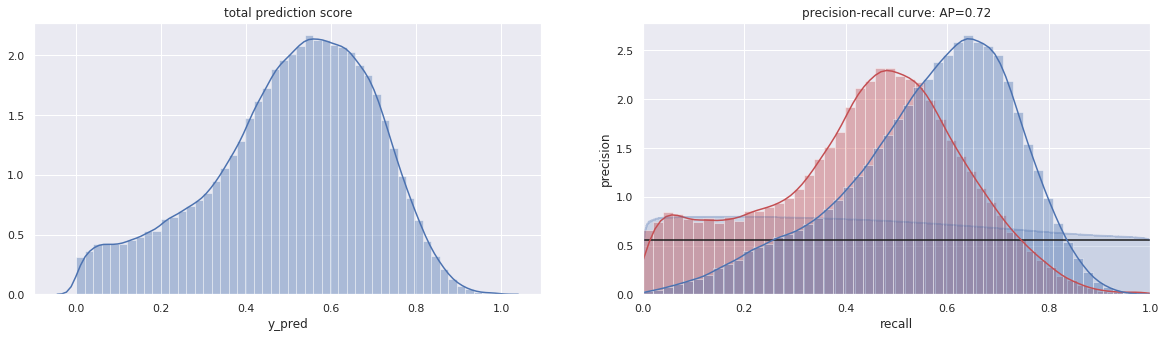

ym:  201905
        acc    recall  precision  f1_score       auc
0  0.569189  0.286144   0.015995  0.030296  0.468688
         pred: 1  pred: 0
true: 1     1427     3560
true: 0    87790   119265


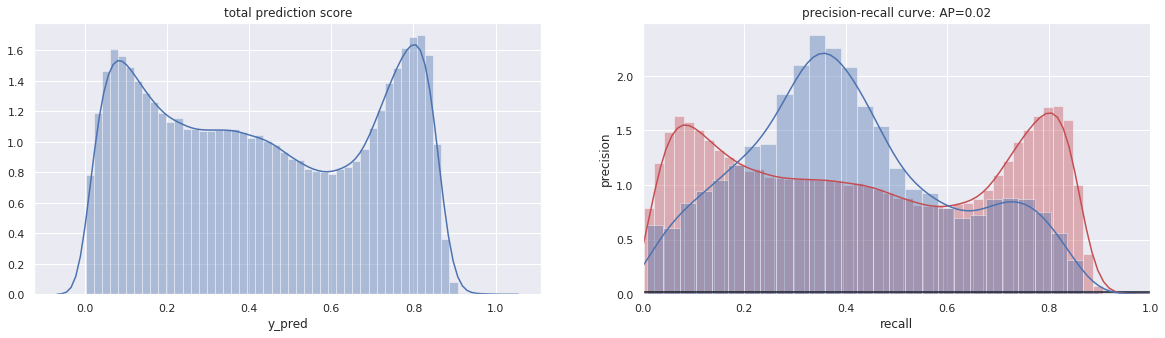

ym:  201903
        acc    recall  precision  f1_score       auc
0  0.477104  0.677414   0.101991  0.177289  0.545558
         pred: 1  pred: 0
true: 1    11787     5613
true: 0   103782    88028


In [43]:
for ym, df in df_dict.items():
    print('='*50)
    print('ym: ', ym)
    label = 'label_note_yn'
    a = evaluate(df[feature_cols], df[label], clf_dict[ym], clf_name='lgb' )

### accuracy w/ confusion matrix

In [28]:
def make_multi_confusion_matrix(df):
    
    df_cf = pd.DataFrame(
        confusion_matrix(df[target_col], df['pred'], labels=np.arange(df[target_col].nunique())), 
        columns = [40, 80, 120, 160])
    
    df_cf['Sum'] = df_cf.sum(axis=1)
    df_cf = df_cf.append(df_cf.sum(axis=0), ignore_index=True)
    
    idx_list = [40, 80, 120, 160] + ['Total']
    idx_dict = {}
    for i in np.arange(len(idx_list)):
        idx_dict[i] = idx_list[i]
        
    df_cf.rename(index=idx_dict, inplace=True)
    
    return df_cf

In [29]:
for ym, df in df_dict.items():
    print('='*50)
    print('ym: ', ym)
#     print('samsung ratio: ', df[df[target_col]==3].shape[0]/df.shape[0])
    print('accuracy: ', accuracy_score(df[target_col], df['pred']))
    display(make_multi_confusion_matrix(df))

ym:  201907
accuracy:  0.7415467609888398


40     80    120     160     Sum
40     29598   3124   1964    4193   38879
80     10295   4631   3583    5993   24502
120     5207   3577  11083   23685   43552
160     5407   4008  16063  204590  230068
Total  50507  15340  32693  238461  337001

ym:  201905
accuracy:  0.37503758126949527


40     80     120    160     Sum
40     19796   9540    6317    126   35779
80      5903   8666    9947    186   24702
120     1825   4560   36662   4401   47448
160     1504   5006   83722  14711  104943
Total  29028  27772  136648  19424  212872

ym:  201903
accuracy:  0.43401380651804955


40    80   120     160     Sum
40     21148   795   636    4592   27171
80     12931  2278  1903   19649   36761
120     5271  1010  2721   70249   79251
160      747   113   823   64890   66573
Total  40097  4196  6083  159380  209756

## shap

In [50]:
from shap_tools import ShapModule

In [51]:
ids = le_dict['mfact_nm'].fit_transform(le_dict['mfact_nm'].classes_)
label_dict = dict(zip(ids,le_dict['mfact_nm'].classes_ ))

In [54]:
ym_dict

{'201907': {'trn': ['201904', '201905'], 'val': '201906', 'tst': '201907'},
 '201905': {'trn': ['201902', '201903'], 'val': '201904', 'tst': '201905'},
 '201903': {'trn': ['201906', '201907'], 'val': '201902', 'tst': '201903'}}

In [52]:
sm_dict = {}

In [55]:
for ym in df_dict.keys():
    sm_dict[ym] = ShapModule(df_merge[df_merge['ym'].isin(ym_dict[ym]['trn'])], clf_dict[ym],
                             feature_cols, idx_col = 'svc_mgmt_num', target_col = target_col,
                             model_type= 'python', label_dict = label_dict )

<class 'lightgbm.basic.Booster'>
<class 'lightgbm.basic.Booster'>
<class 'lightgbm.basic.Booster'>


In [57]:
for ym, sm in sm_dict.items():
    sm.calculate_shap_value(100000, stratified=True) 

elapsed time:  207.8325765132904
elapsed time:  57.58562874794006
elapsed time:  52.86446142196655


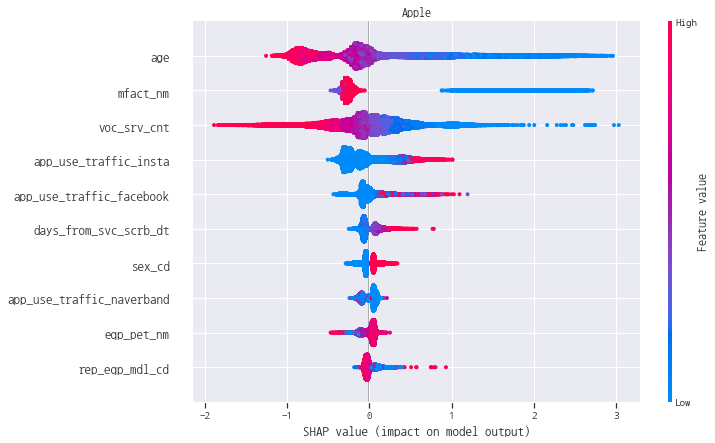

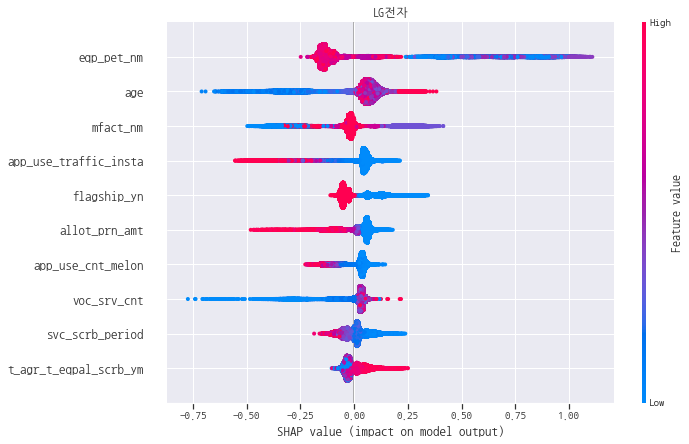

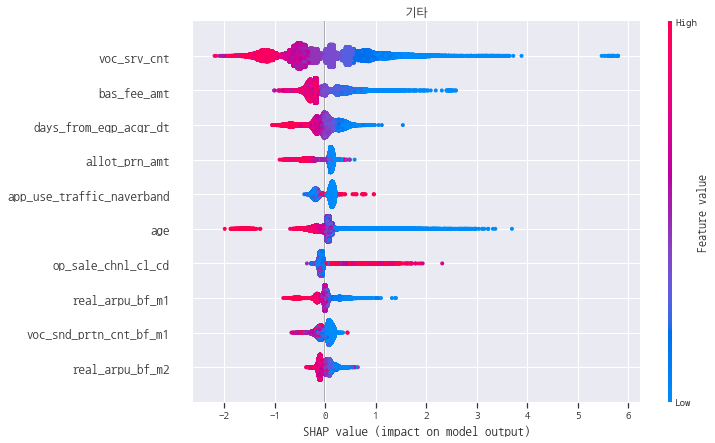

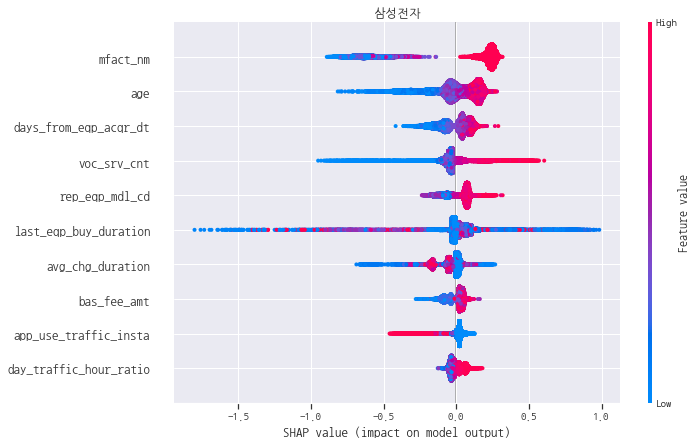

In [58]:
sm_dict['201907'].multiclass_summary_plot()

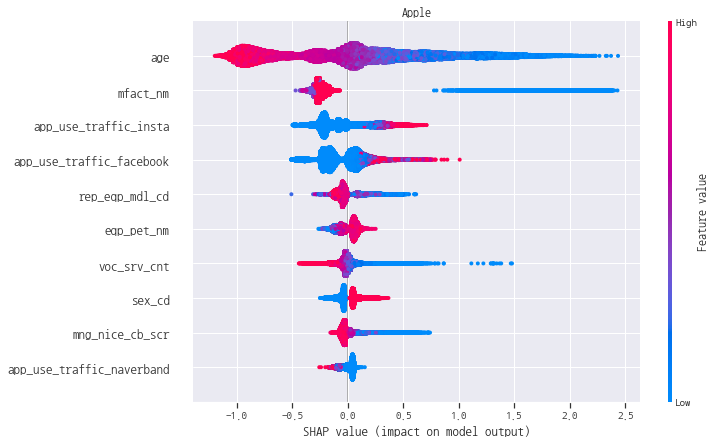

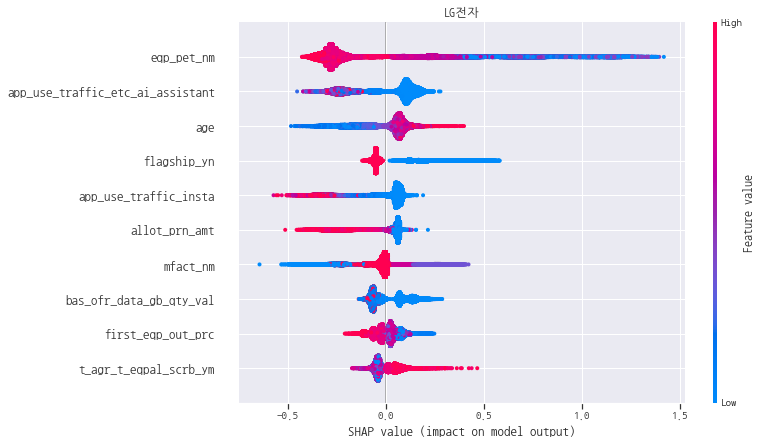

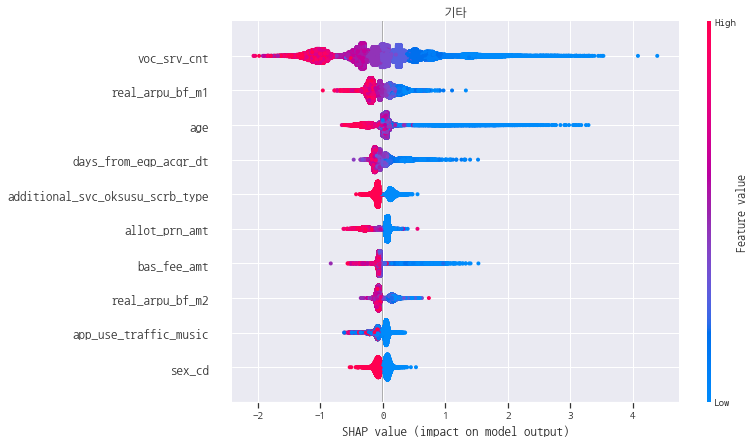

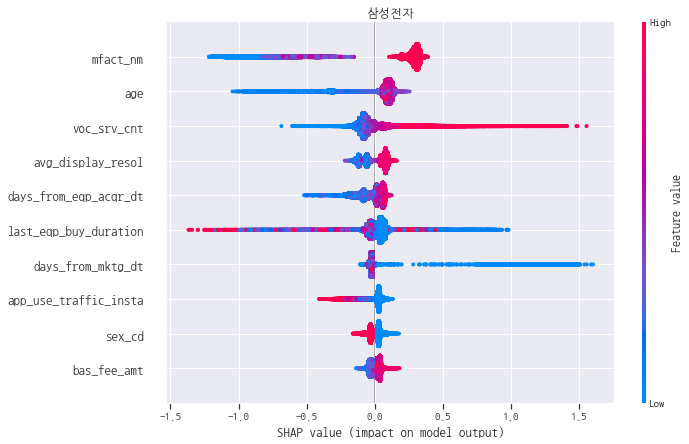

In [59]:
sm_dict['201905'].multiclass_summary_plot()

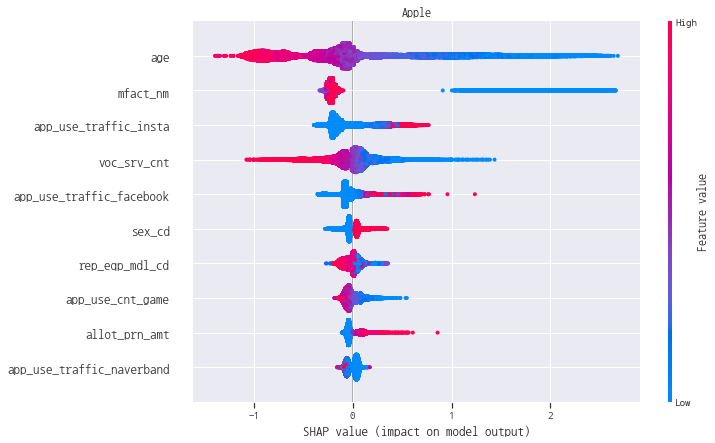

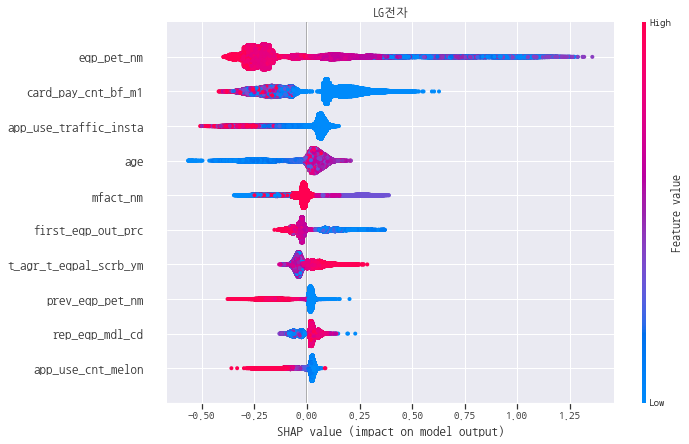

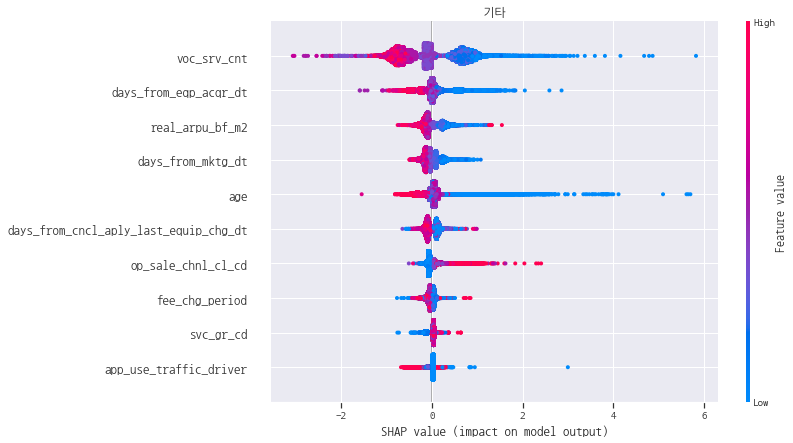

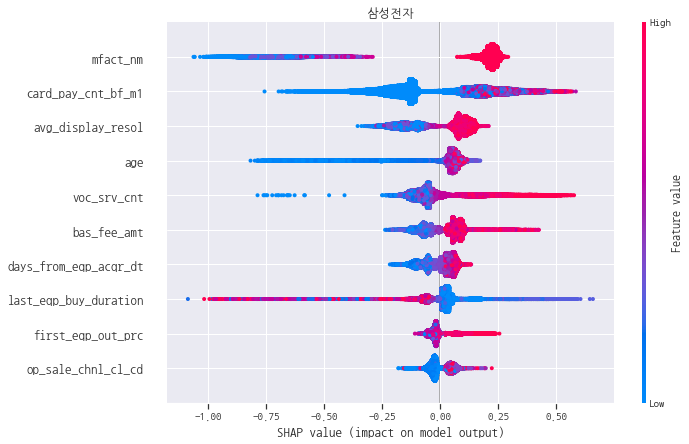

In [60]:
sm_dict['201903'].multiclass_summary_plot()

In [61]:
sm_dict['201907'].sample_df.shape, sm_dict['201905'].sample_df.shape, sm_dict['201903'].sample_df.shape

((99998, 335), (99998, 335), (99998, 335))

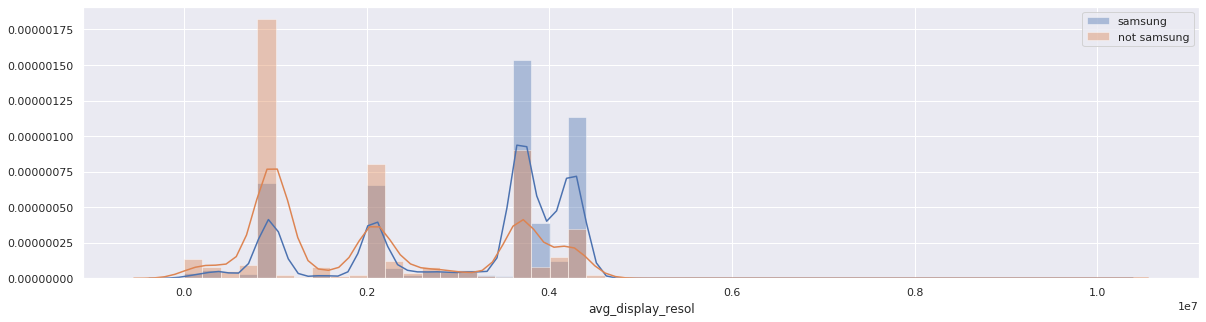

In [63]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201903'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['avg_display_resol'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['avg_display_resol'], label='not samsung')
plt.legend()

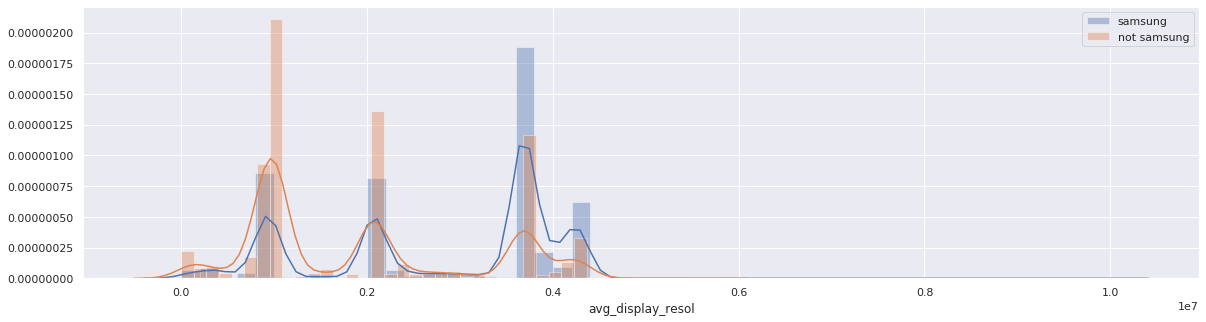

In [64]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201905'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['avg_display_resol'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['avg_display_resol'], label='not samsung')
plt.legend()

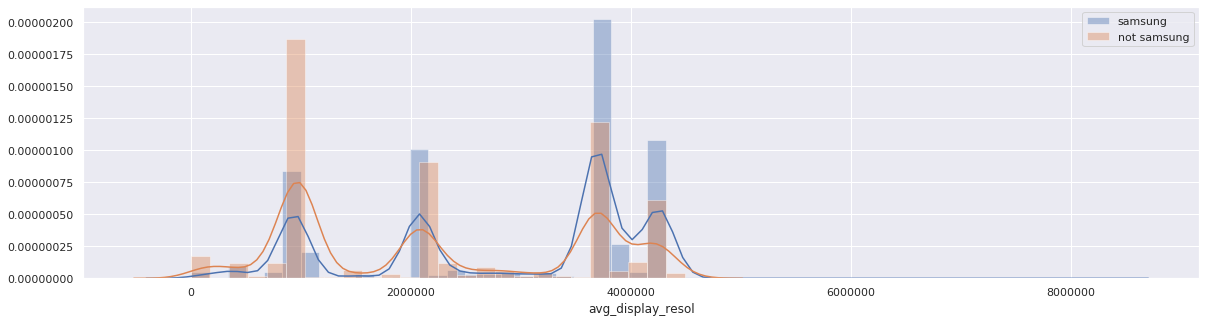

In [65]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201907'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['avg_display_resol'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['avg_display_resol'], label='not samsung')
plt.legend()

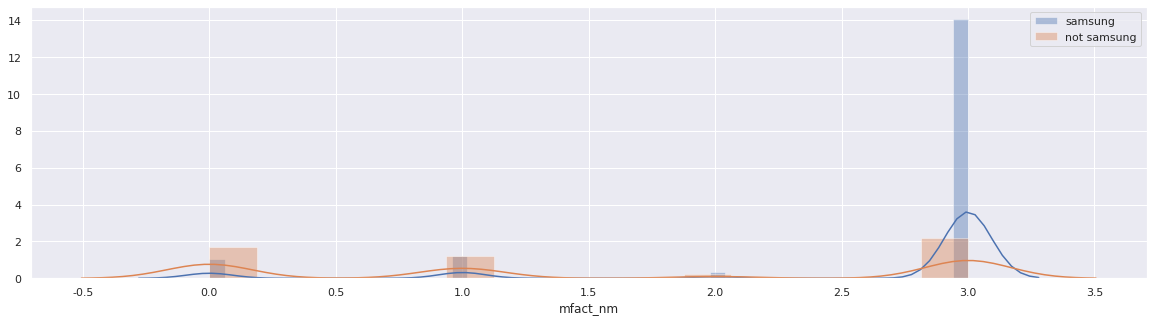

In [66]:
sns.set(rc={'figure.figsize': (20,5)})
# plt.xlim(0,150000)

df_sample = sm_dict['201907'].sample_df.copy()

sns.distplot(df_sample[df_sample['label_mfact_nm']==3]['mfact_nm'], label='samsung')
sns.distplot(df_sample[df_sample['label_mfact_nm']!=3]['mfact_nm'], label='not samsung')
plt.legend()

In [67]:
target_col

'label_mfact_nm'

In [71]:
df_merge.ym.value_counts()

201907    337001
201906    255229
201904    240442
201902    239118
201905    212872
201903    209756
Name: ym, dtype: int64

In [72]:
df_merge.ym.unique()

array(['201902', '201903', '201904', '201905', '201906', '201907'],
      dtype=object)

In [74]:
for ym in df_merge.ym.unique():
    print('='*50)
    print('ym: ', ym)
    display(df_merge[df_merge['ym']==ym].label_mfact_nm.value_counts().head(20))

ym:  201902


3    192660
0     28679
1     15883
2      1896
Name: label_mfact_nm, dtype: int64

ym:  201903


3    164214
0     27746
1     16743
2      1053
Name: label_mfact_nm, dtype: int64

ym:  201904


3    169062
1     41389
0     28428
2      1563
Name: label_mfact_nm, dtype: int64

ym:  201905


3    157166
1     27965
0     27034
2       707
Name: label_mfact_nm, dtype: int64

ym:  201906


3    195269
1     31932
0     27386
2       642
Name: label_mfact_nm, dtype: int64

ym:  201907


3    287554
0     24839
1     23877
2       731
Name: label_mfact_nm, dtype: int64

In [78]:
df_merge[(df_merge['ym']=='201902') & (df_merge['label_mfact_nm']==0)].label_eqp_pet_nm.value_counts()

아이폰XS                11867
아이폰XR                 6333
아이폰7                  3218
아이폰XS_MAX             3134
아이폰X                  2893
아이폰6S                  786
아이폰8                   375
아이폰7+                   43
아이폰8+                   14
IPAD PRO 12.9 3세대        7
IPAD PRO 11              4
R아이폰XS                   2
아이폰6                     1
IPAD PRO 10.5            1
IPAD 9.7                 1
Name: label_eqp_pet_nm, dtype: int64

In [77]:
df_merge[(df_merge['ym']=='201902') & (df_merge['label_mfact_nm']==1)].label_eqp_pet_nm.value_counts()

Q9             5737
G7             2504
X5(2018)       1647
X410           1513
G8             1445
V40             957
Q7              747
LG Folder       481
LTE 스마트 폴더      292
Q8(2018)        277
X4+             194
V35              66
BTS EDITION      18
V30               2
G6                2
V30+ ThinQ        1
Name: label_eqp_pet_nm, dtype: int64

In [73]:
for ym in df_merge.ym.unique():
    print('='*50)
    print('ym: ', ym)
    display(df_merge[df_merge['ym']==ym].label_eqp_pet_nm.value_counts().head(20))

ym:  201902


갤럭시S10              49368
갤럭시S10+             35459
갤럭시노트9              21394
갤럭시S8               14843
갤럭시S10E             12764
아이폰XS               11867
갤럭시 WIDE3           11065
갤럭시A6                9260
갤럭시A9 PRO (2018)     8764
갤럭시S9                6887
갤럭시노트8               6693
아이폰XR                6333
Q9                   5737
갤럭시A8 Star           4785
아이폰7                 3218
아이폰XS_MAX            3134
아이폰X                 2893
G7                   2504
갤럭시A7(2019)          2409
J5 2017              2303
Name: label_eqp_pet_nm, dtype: int64

ym:  201903


갤럭시S10 5G           49772
갤럭시S10              17343
갤럭시S10E             15520
갤럭시 WIDE3           12510
갤럭시노트9              12183
갤럭시S10+             12001
아이폰XS               11528
갤럭시S8               11443
갤럭시A9 PRO (2018)     7480
아이폰XR                6750
Q9                   5705
갤럭시노트8               5215
갤럭시A8 Star           3747
갤럭시S9                3527
아이폰XS_MAX            2958
아이폰X                 2800
갤럭시A6                2711
아이폰7                 2673
G8                   2429
갤럭시A7(2019)          2286
Name: label_eqp_pet_nm, dtype: int64

ym:  201904


갤럭시S10 5G           87714
V50                 24429
아이폰XS               11542
갤럭시S10E             10960
갤럭시 WIDE3            8649
아이폰XR                8047
갤럭시A30               7756
갤럭시S10               7323
갤럭시A9 PRO (2018)     7050
갤럭시S8                6918
갤럭시A8(2018)          5377
Q9                   4537
갤럭시노트9               4333
X4(2019)             4263
갤럭시 WIDE4            4114
갤럭시A8 Star           3408
아이폰7                 3193
갤럭시노트8               3148
갤럭시S10+              2969
아이폰X                 2436
Name: label_eqp_pet_nm, dtype: int64

ym:  201905


갤럭시S10 5G           93464
갤럭시 WIDE4           18646
V50                 15964
아이폰XR                9891
아이폰XS                9497
갤럭시S10E              9371
갤럭시A9 PRO (2018)     5132
갤럭시A30               4814
갤럭시S10               3265
갤럭시노트9               3209
아이폰7                 3065
갤럭시A50               2909
Q9                   2666
갤럭시A7(2019)          2480
갤럭시A8 Star           2403
갤럭시S8                2343
Q7                   2253
X6                   1971
갤럭시노트8               1860
아이폰6S                1772
Name: label_eqp_pet_nm, dtype: int64

ym:  201906


갤럭시S10 5G           122541
V50                  18158
갤럭시 WIDE4            17855
갤럭시노트9               11769
아이폰XR                11485
아이폰XS                10099
갤럭시A50                6923
갤럭시S10E               6737
갤럭시A30                3754
갤럭시A9 PRO (2018)      3730
X6                    3460
아이폰7                  2973
갤럭시노트8                2857
갤럭시S10                2725
갤럭시A7(2019)           2405
갤럭시A40                2399
Q9                    2396
Q7                    2256
갤럭시A8 Star            1906
갤럭시폴더2                1820
Name: label_eqp_pet_nm, dtype: int64

ym:  201907


갤럭시노트10             177329
갤럭시S10 5G            42699
갤럭시 WIDE4            18919
아이폰XR                10528
V50                   9546
아이폰XS                 8545
갤럭시S10E               7771
갤럭시A50                7395
갤럭시노트9                7283
갤럭시A40                4884
갤럭시A9 PRO (2018)      4467
아이폰7                  4136
X6                    3269
갤럭시A30                3035
Q9                    2882
갤럭시폴더2                2559
V40                   2165
갤럭시S10                2154
갤럭시노트8                2092
갤럭시A7(2019)           1885
Name: label_eqp_pet_nm, dtype: int64